### Generating human faces with Adversarial Networks (5 points)
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on Based on https://github.com/Lasagne/Recipes/pull/94 .


In [22]:
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from itertools import count
from IPython import display
import warnings
import time

In [3]:
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset(dimx=36, dimy=36)

#preprocess faces
data = np.float32(data).transpose([0,3,1,2]) / 255.

IMG_SHAPE = data.shape[1:]

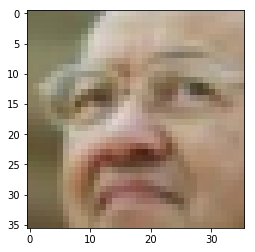

In [4]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])].transpose([1,2,0]),
           cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [5]:
use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

Torch version: 1.0.1.post2
Using GPU


In [6]:
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    #print(noise.shape)
    return noise.cuda() if use_cuda else noise.cpu()
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape=shape
    def forward(self,input):
        return input.view(self.shape)
    
def save_checkpoint(state, filename):
    torch.save(state, filename)

In [35]:
CODE_SIZE = 256

# automatic layer name maker. Don't do this in production :)
ix = ('layer_%i'%i for i in count())

generator = nn.Sequential()

generator.add_module(next(ix), nn.Linear(CODE_SIZE, 10*8*8)) #output 10*8*8
generator.add_module(next(ix), nn.ELU())
generator.add_module(next(ix), Reshape([-1, 10, 8, 8])) #output 10x8x8

generator.add_module(next(ix), nn.ConvTranspose2d(10, 64, kernel_size=(5,5))) #output 64x12x12
generator.add_module(next(ix), nn.ELU())
generator.add_module(next(ix), nn.ConvTranspose2d(64, 64, kernel_size=(5,5))) #output 64x16x16
generator.add_module(next(ix), nn.ELU())
generator.add_module(next(ix), nn.Upsample(scale_factor=2)) #output 64x32x32

generator.add_module(next(ix), nn.ConvTranspose2d(64, 32, kernel_size=(5,5))) #output 32x36x36
generator.add_module(next(ix), nn.ELU())
generator.add_module(next(ix), nn.ConvTranspose2d(32, 32, kernel_size=(5,5))) #output 32x40x40
generator.add_module(next(ix), nn.ELU())

generator.add_module(next(ix), nn.Conv2d(32, 3, kernel_size=(5,5))) #output 3x36x36
#generator.add_module(next(ix), nn.Sigmoid())

if use_cuda: generator.cuda()

In [8]:
generated_data = generator(sample_noise_batch(5))
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, \
"generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generated_data.shape)

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


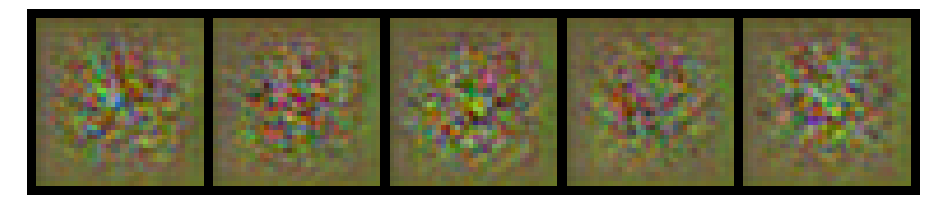

In [9]:
plt.figure(figsize=(16,10))
plt.axis('off')
plt.imshow(utils.make_grid(generated_data).cpu().detach().numpy().transpose((1,2,0)).clip(0,1)*10)
plt.show()

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [10]:
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    batch = torch.tensor(data[idxs], dtype=torch.float32)
    return batch.cuda() if use_cuda else batch.cpu()

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [ ]:
discriminator = nn.Sequential()

## Got mediocre result
### YOUR CODE - create convolutional architecture for discriminator
### Note: please start simple. A few convolutions & poolings would do, inception/resnet is an overkill

discriminator.add_module("conv1", nn.Conv2d(3, 32, 5)) #output 32x32x32
discriminator.add_module("elu1", nn.ELU())
#discriminator.add_module("pool2d", nn.MaxPool2d(2, stride=2)) #output 32x16x16
discriminator.add_module('avgpool1', nn.AdaptiveAvgPool2d((16,16)))
discriminator.add_module("conv2", nn.Conv2d(32, 64, 5)) #output 64x12x12
discriminator.add_module("elu2", nn.ELU())
discriminator.add_module("conv3", nn.Conv2d(64, 10, 5)) #output 10x8x8
discriminator.add_module("elu3", nn.ELU())
discriminator.add_module("reshape", Reshape([-1, 10*8*8]))
discriminator.add_module("linear1", nn.Linear(10*8*8, CODE_SIZE)) #output 256
discriminator.add_module("elu4", nn.ELU())
discriminator.add_module("linear1", nn.Linear(CODE_SIZE, 1))

if use_cuda: discriminator.cuda()

In [ ]:
discriminator = nn.Sequential()

# Got bad results
### YOUR CODE - create convolutional architecture for discriminator
### Note: please start simple. A few convolutions & poolings would do, inception/resnet is an overkill

discriminator.add_module("conv1", nn.Conv2d(3, 32, 5)) #output 32x32x32
discriminator.add_module("lrelu1", nn.LeakyReLU(0.2))
discriminator.add_module("conv2", nn.Conv2d(32, 64, 3)) #output 64x30x30
discriminator.add_module("bn1", nn.BatchNorm2d(64))
discriminator.add_module("lrelu2", nn.LeakyReLU(0.2))
discriminator.add_module('avgpool1', nn.AdaptiveAvgPool2d((15,15)))
discriminator.add_module("conv3", nn.Conv2d(64, 128, 4)) #output 128x12x12
discriminator.add_module("bn2", nn.BatchNorm2d(128))
discriminator.add_module("lrelu3", nn.LeakyReLU(0.2))
discriminator.add_module('avgpool2', nn.AdaptiveAvgPool2d((6,6))) #output 128x6x6
discriminator.add_module("conv4", nn.Conv2d(128, 256, 4)) #output 256x3x3
discriminator.add_module("bn3", nn.BatchNorm2d(256))
discriminator.add_module("lrelu4", nn.LeakyReLU(0.2))
discriminator.add_module("reshape", Reshape([-1, 256*3*3]))
discriminator.add_module("linear1", nn.Linear(256*3*3, 1)) #output 256

if use_cuda: discriminator.cuda()

In [36]:
discriminator = nn.Sequential()

# Moreless fine
### YOUR CODE - create convolutional architecture for discriminator
### Note: please start simple. A few convolutions & poolings would do, inception/resnet is an overkill

discriminator.add_module("conv1", nn.Conv2d(3, 32, 5)) #output 32x32x32
discriminator.add_module("lrelu1", nn.LeakyReLU(0.2))
discriminator.add_module('avgpool1', nn.AdaptiveAvgPool2d((16,16))) #output 32x16x16

discriminator.add_module("conv2", nn.Conv2d(32, 64, 5, 1, 2)) #output 64x16x16
discriminator.add_module("bn1", nn.BatchNorm2d(64))
discriminator.add_module("lrelu2", nn.LeakyReLU(0.2))
discriminator.add_module('avgpool2', nn.AdaptiveAvgPool2d((8,8))) #output 64x8x8

discriminator.add_module("conv3", nn.Conv2d(64, 128, 5, 1, 2)) #output 128x8x8
discriminator.add_module("bn2", nn.BatchNorm2d(128))
discriminator.add_module("lrelu3", nn.LeakyReLU(0.2))
discriminator.add_module('avgpool2', nn.AdaptiveAvgPool2d((4,4))) #output 128x4x4

discriminator.add_module("conv4", nn.Dropout(0.5))
discriminator.add_module("reshape", Reshape([-1, 128*4*4]))
discriminator.add_module("linear1", nn.Linear(128*4*4, 1)) #output 1

if use_cuda: discriminator.cuda()

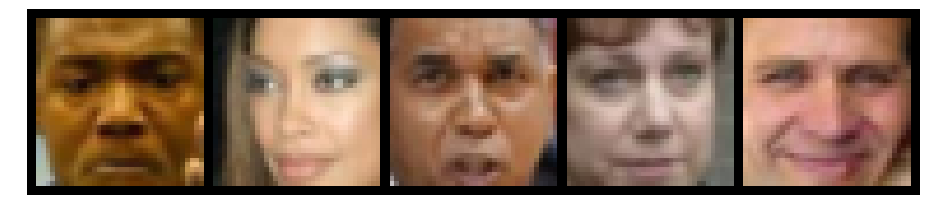

torch.Size([5, 1])

In [37]:
sample = sample_data_batch(5)
plt.figure(figsize=(16,10))
plt.axis('off')
plt.imshow(utils.make_grid(sample).cpu().detach().numpy().transpose((1,2,0)).clip(0,1))
plt.show()
discriminator(sample).shape

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

![img](https://s24.postimg.org/cw4nognxx/gan.png)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [38]:
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise)
    
    disc_on_generated_data = discriminator(generated_data)
    
    logp_gen_is_real = F.logsigmoid(disc_on_generated_data)
    
    loss = -1 * torch.mean(logp_gen_is_real)
    
    return loss

In [39]:
loss = generator_loss(sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 0, "loss must be scalar"

tensor(0.8705, device='cuda:0', grad_fn=<MulBackward0>)


In [40]:
def discriminator_loss(real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    disc_on_real_data = discriminator(real_data)
    disc_on_fake_data = discriminator(generated_data)
    
    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = F.logsigmoid(1 - disc_on_fake_data)
    
    loss = -1 * torch.mean(logp_real_is_real + logp_gen_is_fake)
    return loss

In [41]:
loss = discriminator_loss(sample_data_batch(32), 
                   generator(sample_noise_batch(32)))

print(loss)

assert len(loss.shape) == 0, "loss must be scalar"

tensor(0.9432, device='cuda:0', grad_fn=<MulBackward0>)


### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [42]:
def sample_images(nrow, ncol, sharp=False):
    with torch.no_grad():
        images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        plt.axis('off')
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    plt.show()

def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = F.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = F.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5, range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))', alpha=0.5, range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [43]:
#optimizers
disc_opt = torch.optim.SGD(discriminator.parameters(), weight_decay=1e-4, lr=5e-3)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)
last_epoch = 0

In [ ]:
WEIGHTS_PATH = './weights/dcgan.pth.tar'

if (torch.cuda.is_available()):
    checkpoint = torch.load(f=WEIGHTS_PATH)
else:
    net = nn.DataParallel(net)
    checkpoint = torch.load(map_location='cpu', f=WEIGHTS_PATH)
    
generator.load_state_dict(checkpoint['gen_weights'])
discriminator.load_state_dict(checkpoint['disc_weights'])
last_epoch = checkpoint['last_epoch']
disc_opt.load_state_dict(checkpoint['disc_optim'])
gen_opt.load_state_dict(checkpoint['gen_optim'])

In [73]:
def gaussian(ins, mean=0, stddev=0.05):
    noise = torch.autograd.Variable(ins.data.new(ins.size()).normal_(mean, stddev))
    return ins + noise

epoch 42300, Generator loss 2.2086067, discriminator loss 0.0311077
time taken (100 epochs) 15 sec


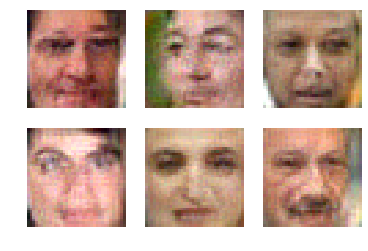

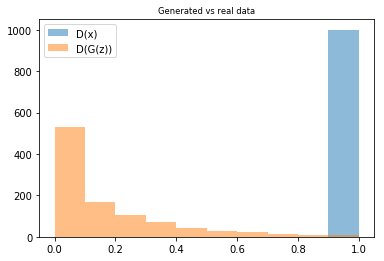

KeyboardInterrupt: 

In [75]:
warnings.simplefilter('ignore')

batch_size = 100
disc_loss = 0
gen_loss = 0
start = time.time()

for epoch in range(last_epoch, 50000):
    # Train discriminator
    for i in range(5):
        real_data = sample_data_batch(batch_size)
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(gaussian(real_data), gaussian(fake_data))
        disc_opt.zero_grad()
        loss.backward()
        disc_opt.step()
        disc_loss = loss.item()
        
    # Train generator
    for j in range(1):
        noise = sample_noise_batch(batch_size)
        loss = generator_loss(noise)
        gen_opt.zero_grad()
        loss.backward()
        gen_opt.step()
        gen_loss = loss.item()
    
    if epoch %100==0:
        end = time.time()
        display.clear_output(wait=True)
        print("epoch %d, Generator loss %.7f, discriminator loss %.7f" % (epoch, gen_loss, disc_loss))
        print("time taken (100 epochs) %.0f sec" % (end - start))
        sample_images(2,3,True)
        sample_probas(1000)
        start = time.time()
    last_epoch = epoch

In [79]:
print(epoch)
save_checkpoint({
    'gen_weights': generator.state_dict(),
    'disc_weights' : discriminator.state_dict(),
    'gen_optim' : gen_opt.state_dict(),
    'disc_optim' : disc_opt.state_dict(),
    'last_epoch' : last_epoch
}, "./weights/dcgan.pth.tar")

42312


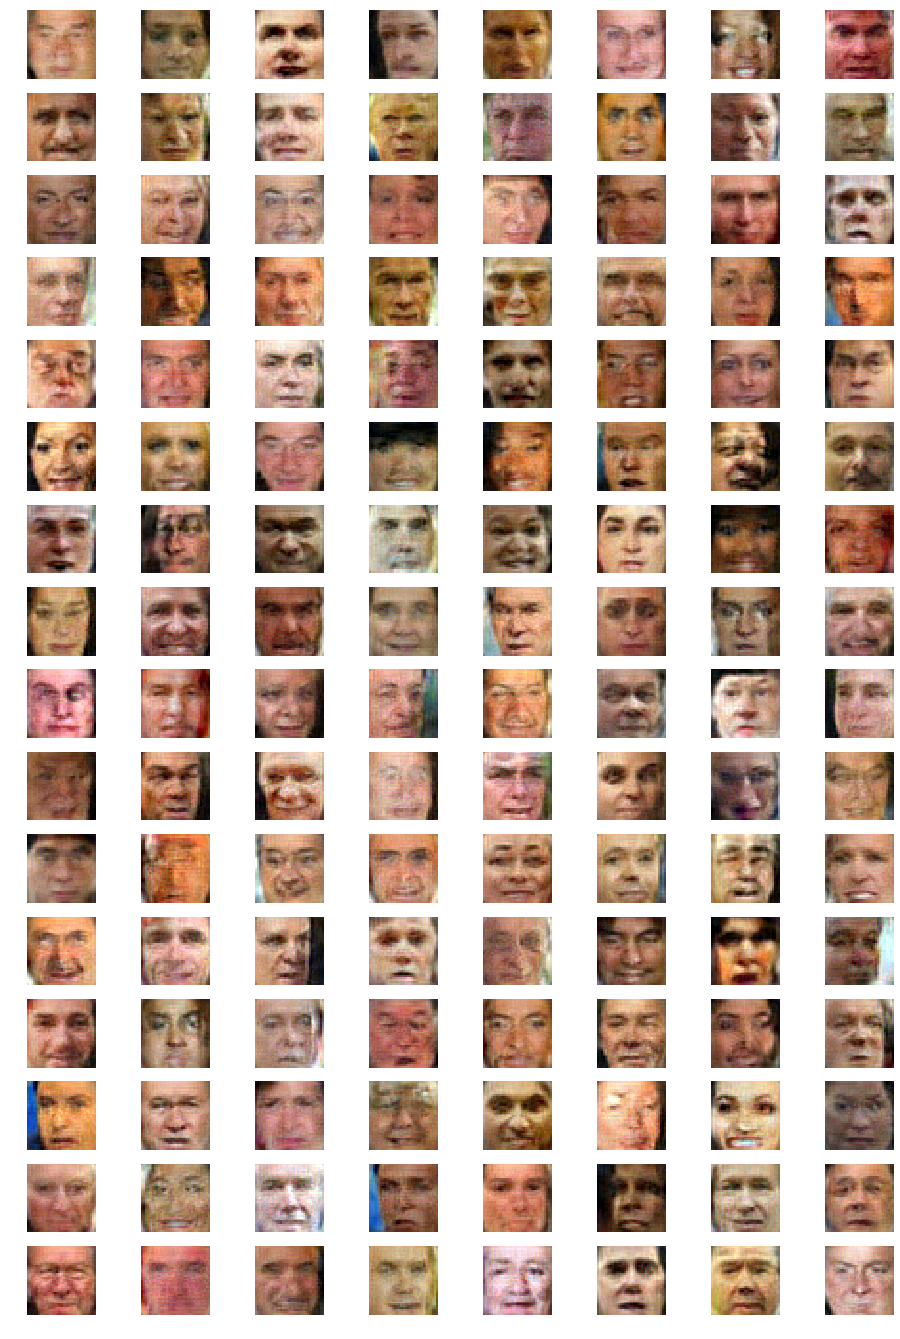

In [77]:
plt.figure(figsize=[16, 24])
sample_images(16, 8)

# Note: a no-nonsense neural network should be able to produce reasonably good images after 15k iterations
# By "reasonably good" we mean "resembling a car crash victim" or better

### Evaluation
__The code below__ dumps a batch of images so that you could use them for precision/recall evaluation.

Please generate the same number of images as for autoencoders for a fair comparison.

In [78]:
num_images = len(data)
batch_size = 100

all_images = []

for batch_i in range(int((num_images - 1) / batch_size + 1)):
    with torch.no_grad():
        images = generator(sample_noise_batch(batch_size=batch_size))
        images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(np.min(data), np.max(data))
        
    all_images.append(images)
    
all_images = np.concatenate(all_images, axis=0)[:num_images]

np.savez("./gan.npz", Pictures=all_images)